# Проверка первых записей калибровочных сессий 

Цель:
- Проверить фотометку
- Посмотреть работает ли такая структура эпох

Dataset: pilot/01_calib_sessions <br>
Date: 2025-12-19

In [1]:
# === project setup ===
from pathlib import Path
import sys

PROJECT_ROOT = Path().resolve().parents[0]
print("PROJECT_ROOT =", PROJECT_ROOT)

if not (PROJECT_ROOT / "src").exists():
    raise RuntimeError("src directory not found — wrong PROJECT_ROOT")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

PROJECT_ROOT = C:\Users\hodor\Documents\lab-Shishkin\projects\feedback-quasi\analysis\fb-quasi_analysis


In [2]:
# === imports ===
from h5py import File 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import copy
import pandas as pd
import importlib

In [89]:
from src.utils.parse_h5df import * 
from src.utils.fb_quasi_parse_events import reparse_trigger_v1_1, trigger_to_event_v1_1
from src.utils.events import * 
from src.utils.spectral_analysis import *
from src.utils.transformations import unit_to_db
from src.utils.montage_processing import *
from src.utils.rereferencing import *

In [110]:
def get_topo_positions(fl_montage):
    df = pd.read_csv(fl_montage, sep='\t')
    th = np.pi / 180 * np.array(df.theta.values)
    df['y'] = np.round(np.array(df.radius.values) * np.cos(th), 2)
    df['x'] = np.round(np.array(df.radius.values) * np.sin(th), 2)
    return df[['x', 'y']].values

In [4]:
# === config ===
DATASET = "pilot/01_calib_sessions"
SESSION = "02ES_ses10.12.2025_calib_v1.1"
DATA_FOLDER = os.path.join(r"..\data\raw\pilot\01_calib_sessions", SESSION, "data")
RECORD = "02-OM.hdf"

# 3 loops of 6 trials. 
# Each trial contains 4 motor phases (1.5 s) followed by 1 rest phase (5 s). 
# We'll call them motor trials (4x1.5) and rest trials (5 s). 

In [111]:
EEG_CHANNELS = np.arange(64)
CED_FILE = r"../resources/mks64_standard.ced"

ch_labels = get_channel_names(CED_FILE)
positions = get_topo_positions(CED_FILE)

labels_ROA = ["FC5", "FC3", "FC1", "C1", "CP1", "CP3", "CP5", "C5", "C3"] 
idxs_ROA = [find_ch_idx(ch, CED_FILE) for ch in labels_ROA]
idx_Fz = find_ch_idx("Fz", CED_FILE)

In [106]:
from matplotlib import colormaps as cm
from matplotlib.colors import ListedColormap
viridisBig = cm.get_cmap('jet')
newcmp = ListedColormap(viridisBig(np.linspace(0, 1, 15)))

In [6]:
Fs = 1000 # Hz
s_to_idx = lambda x: int(x * Fs)
ms_to_idx = lambda x: int(x // 1000 * Fs)

In [7]:
config_info = {
    "motor_trial_dur": 1200,
    "rest_trial_dur": 5000
    }

In [59]:
# === data ===
data, _ = load_h5df(os.path.join(DATA_FOLDER, RECORD))
data.shape

(422688, 67)

In [178]:
# === preprocessing === 

# bandpass filtering
raw_eeg = data[:, EEG_CHANNELS] * 1E6 # uV
filt_eeg = bandpass_filter(raw_eeg, fs=Fs, low=8, high=30)

# CAR
car_eeg = apply_car(filt_eeg)

In [179]:
# === trigger ===
trigger = ttl2binary(data[:, -1], bit_index=0)
trigger = reverse_trigger(trigger)

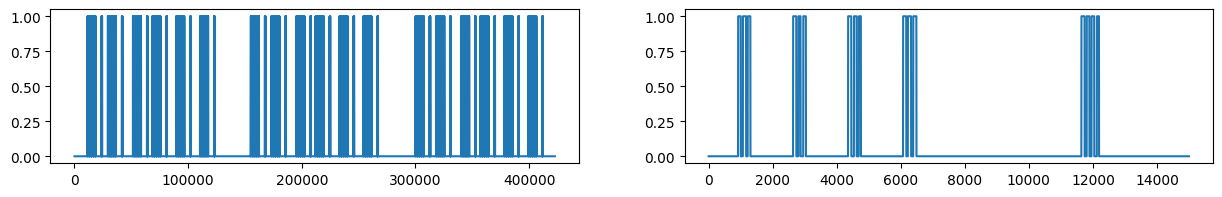

In [180]:
fig, ax = plt.subplots(1, 2, figsize=(15, 2))
ax[0].plot(trigger)
start_time, end_time = 30, 45 # s
ax[1].plot(trigger[start_time*1000:end_time*1000])

In [65]:
# === events & epochs === 
events, trigger_sum = trigger_to_event_v1_1(trigger, window_size=600)        # 1 - motor, 2 - rest

In [177]:
def plot_events_checker():
    start_time = 25 # s
    end_time = 45 #len(trigger)/1000 # s
    timeline = np.arange(len(trigger))
    mask = np.where((timeline >= start_time*1000) & (timeline <= end_time*1000))

    fig, ax = plt.subplots(2, 1, figsize=(15, 4))

    ax[0].plot(timeline[mask], trigger[mask], label='trigger')
    ax[0].plot(timeline[mask], events[mask], label='event')
    ax[0].legend()
    ax[0].grid()

    ch = 10
    ax[1].plot(timeline[mask], filt_eeg[mask]);
    ax[1].plot(timeline[mask], events[mask]*100, label='event', color='black')
    ax[1].grid()
plot = False
if plot:
    plot_events_checker()

In [69]:
idx_motor = receive_epochs(events, event_code=1)
idx_rest = receive_epochs(events, event_code=2)

In [70]:
events_info = {
    "motor": 
        {
            "event_code": 1, 
            "trial_dur_ms": int(np.mean(np.diff(idx_motor)))
        },
    "rest": 
        {
            "event_code": 2, 
            "trial_dur_ms":  int(np.mean(np.diff(idx_rest)))
        }
}

reveive_events_info(events, events_info)

In [71]:
events_info

{'motor': {'event_code': 1, 'trial_dur_ms': 6768, 'num': 18, 'dur': 121.8},
 'rest': {'event_code': 2, 'trial_dur_ms': 5580, 'num': 18, 'dur': 100.4}}

In [72]:
epochs_motor = slice_epochs(filt_eeg, idx_motor)        # data in slices (n_epochs, n_samples_in_epoch, n_channels)
epochs_rest = slice_epochs(filt_eeg, idx_rest)          # data in slices (n_epochs, n_samples_in_epoch, n_channels)

In [73]:
epochs_motor.shape, epochs_rest.shape

((18, 6751, 64), (18, 5567, 64))

In [148]:
# === CSP === 
from scipy.linalg import eigh
from mne.viz import plot_topomap
import matplotlib.gridspec as gridspec

In [168]:
def cov_epoch(X):
    """
    X: (channels, time)
    """
    C = X @ X.T
    return C / np.trace(C)

def regularize(C, alpha=0.05):
    return (1 - alpha) * C + alpha * np.eye(C.shape[0])

def calculate_CSP(epochs_motor, epochs_rest):
    covs_motor = np.array([cov_epoch(ep.T) for ep in epochs_motor])  # ep: (time, ch)
    C_motor  = covs_motor.mean(axis=0)
    C_motor  = regularize(C_motor,  alpha=0.05)

    covs_rest = np.array([cov_epoch(ep.T) for ep in epochs_rest])  # ep: (time, ch)
    C_rest  = covs_rest.mean(axis=0)
    C_rest = regularize(C_rest, alpha=0.05)
    
    C_sum = C_motor + C_rest
    eigvals, eigvecs = eigh(C_motor, C_sum)     # λ = 1 -> motor class
    
    # сортируем по убыванию собственных значений, первые - лучшие 
    ix = np.argsort(eigvals)[::-1]  # убывание λ
    eigvals = eigvals[ix]
    eigvecs = eigvecs[:, ix]

    ## spatial patterns 
    A = C_sum @ eigvecs
    A /= np.linalg.norm(A, axis=0, keepdims=True) # to normalize

    return eigvals, eigvecs, A

eigvals, eigvecs, A = calculate_CSP(epochs_motor, epochs_rest)

In [189]:
def plot_CSP_components(eigvals, A, positions, ch_labels, row_idx, gs, cmap):
        # первый график: линия eigenvalues
        ax0 = plt.subplot(gs[row_idx, 0])
        ax0.plot(eigvals, "k")
        ax0.scatter(range(len(eigvals)), eigvals, marker="o", s=20)
        ax0.set_ylim(0, 1)
        ax0.set_title("Eigenvalues")
        
        # топоплоты
        ims = []
        idxs = [0, 1, 2, 3, -4, -3, -2, -1]
        vmin = np.min(A[idxs])
        vmax = np.max(A[idxs])
        vmin, vmax = -max(abs(vmin), abs(vmax)), max(abs(vmin), abs(vmax))
        
         # топографические карты
        def plot_topoplot(X, positions, vmin=None, vmax=None, ch_labels=None, axes=None, cmap=None):
                im, cn = plot_topomap(X, positions,  image_interp='cubic', ch_type='eeg', names =ch_labels,
                        size=5, show=False, contours=4, sphere=0.5, 
                        cmap=newcmp, extrapolate='head', axes=axes, vlim=[vmin, vmax])
                return im
        
        for i, idx in enumerate(idxs):
                ax_map = plt.subplot(gs[row_idx, i+1])
                im = plot_topoplot(A[idx], positions, axes=ax_map, cmap=cmap, 
                        vmin=vmin, vmax=vmax)
                comp_number = idx if idx >= 0 else len(ch_labels)+idx
                ax_map.set_title(f"CSP #{comp_number+1}")
                ims.append(im)

        # общий colorbar справа от последнего topomap
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax_map)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(ims[-1], cax=cax)
        cbar.set_ticks([vmin, vmax])
        cbar.set_ticklabels([f"{vmin:.2f}", f"{vmax:.2f}"])
        cbar.ax.yaxis.set_tick_params(labelsize=10)

8-30 Hz -- done.
8-12 Hz -- done.
9-13 Hz -- done.
10-14 Hz -- done.
11-15 Hz -- done.


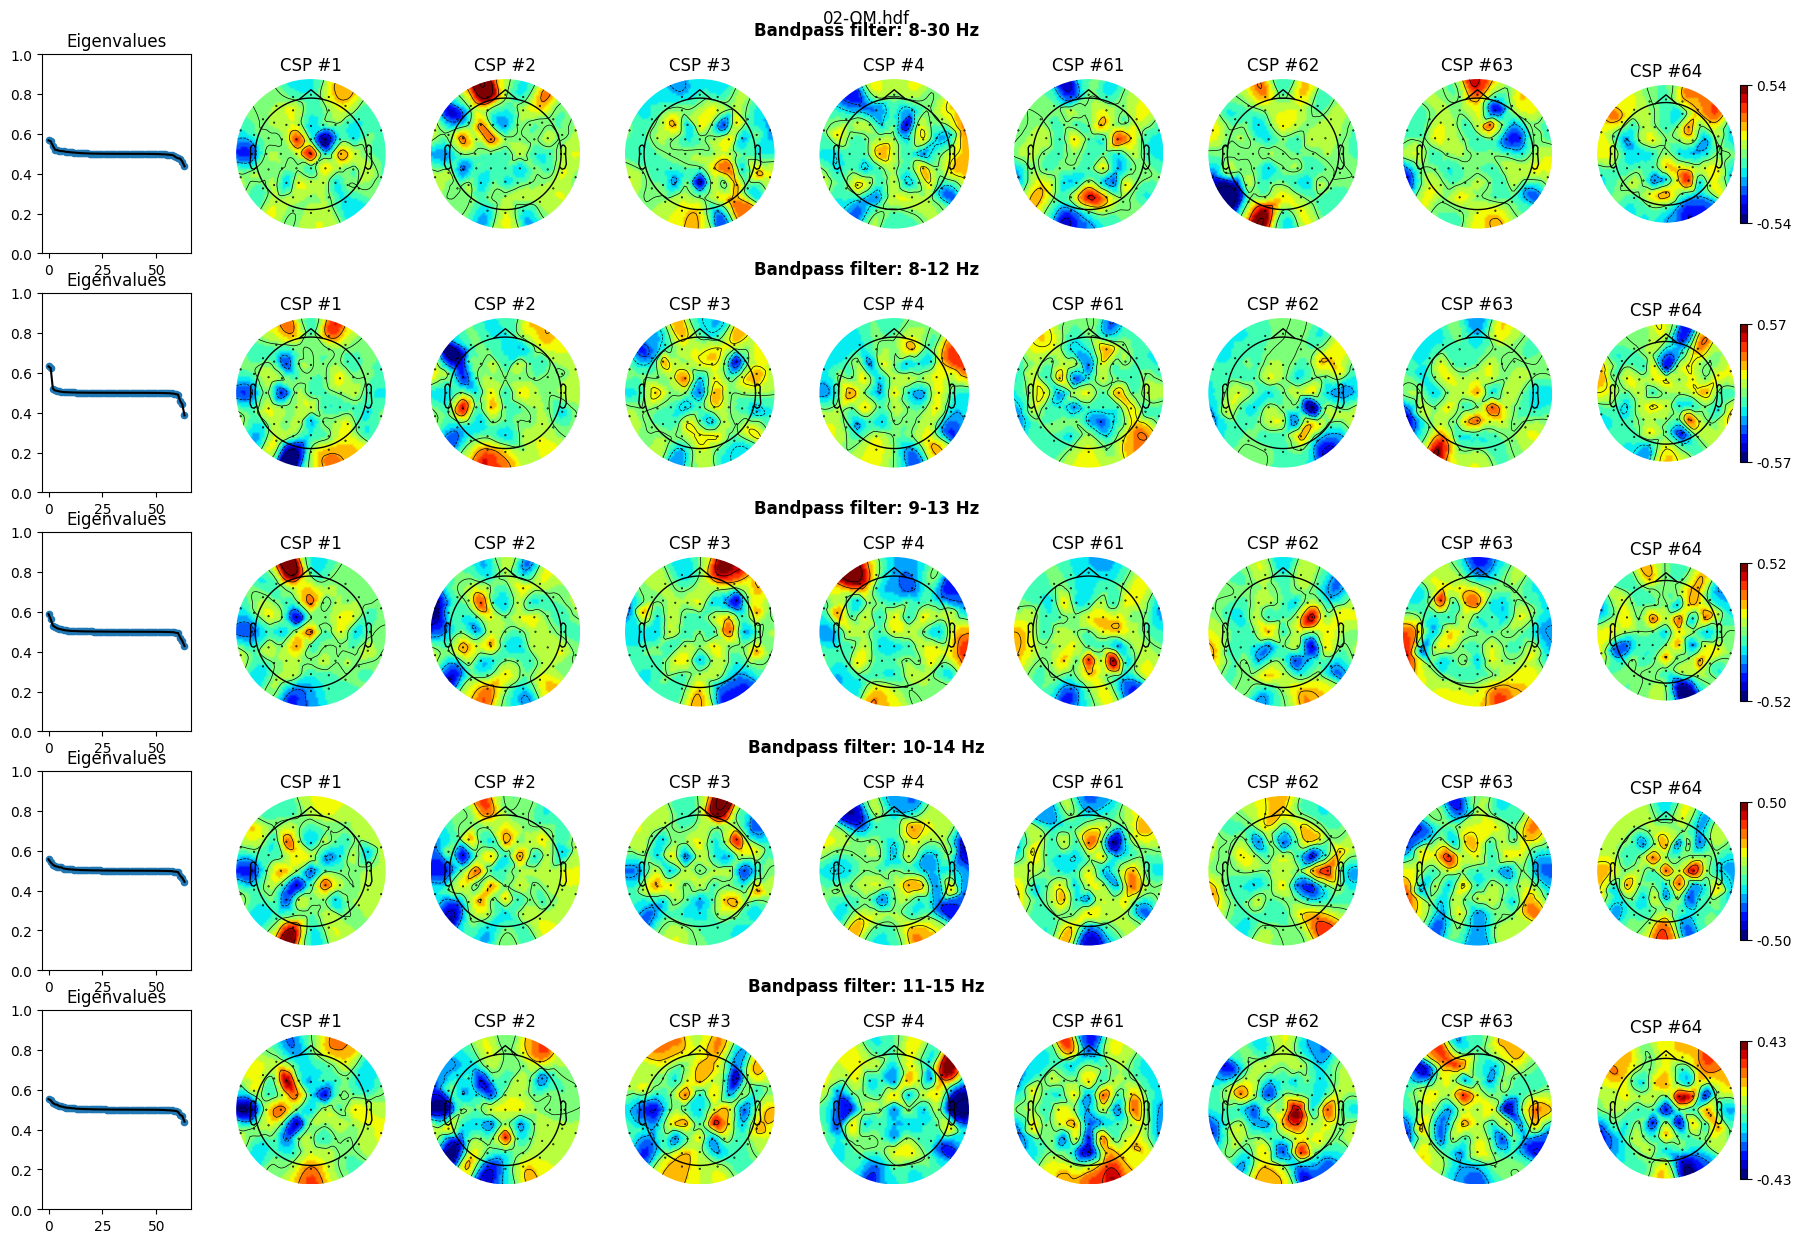

In [ ]:
bands = [[8, 30], [8, 12], [9, 13], [10, 14], [11, 15]]

fig = plt.figure(figsize=(22, 3 * len(bands)))
gs = gridspec.GridSpec(len(bands), 9, height_ratios=[1]*len(bands), wspace=0.3)

for row_idx, (low_f, high_f) in enumerate(bands):
    filt_eeg = bandpass_filter(raw_eeg, fs=Fs, low=low_f, high=high_f)
    epochs_motor, epochs_rest = slice_epochs(filt_eeg, idx_motor), slice_epochs(filt_eeg, idx_rest)
    eigvals, eigvecs, A = calculate_CSP(epochs_motor, epochs_rest)
    
    plot_CSP_components(eigvals, A, positions, ch_labels, row_idx, gs, cmap=newcmp)

    # Добавляем название полосы **над всей строкой**
    ax0 = plt.subplot(gs[row_idx, 0])
    pos = ax0.get_position()  # BBox

    # Добавляем название полосы
    fig.text(0.5, pos.y1 + 0.01, f"Bandpass filter: {low_f}-{high_f} Hz",
             ha='center', va='bottom', fontsize=12, fontweight='bold')
    

    print(f"{low_f}-{high_f} Hz -- done.")
plt.suptitle(RECORD, y=0.92)
plt.show()

In [ ]:
def apply_csp(X, W):
    # X: (epochs, time, channels)
    return np.array([
        (W.T @ ep.T) for ep in X
    ])  # (epochs, n_csp*2, time)

X_csp = apply_csp(X, eigvecs)

In [ ]:
def logvar(X):
    return np.log(np.var(X, axis=2))

features = logvar(X_csp)
features.shape = (n_epochs, 8)

In [ ]:
def plot_trials(data, ax, plot_mean=False, title=None):
    """
    data: array-like (n_epochs, n_samples)
    """
    for i in range(len(data)):
        ax.plot(data[i, :], linewidth=.7)

    if plot_mean:
        avg_data = np.mean(data, axis=0)
        ax.plot(avg_data, color='black', linewidth=2) 
    
    if title is not None:
        ax.set_title(title)
    
    ax.grid()

def plot_two_trial_plots(data1, data2, label1, label2, title):
    import matplotlib.gridspec as gridspec

    fig = plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(2, 1, hspace=0.3, wspace=0.3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])

    plot_trials(data1, ax1, title=label1)
    plot_trials(data2, ax2, title=label2)

    ax2.set_xlabel("Time [ms]")
    ax2.set_ylabel("EEG [uV]")

    fig.suptitle(title)

plot_two_trial_plots(epochs_motor[:, :, idxs_ROA[-1]], 
                    epochs_rest[:, :, idxs_ROA[-1]], 
                    label1="Motor trials", label2="Rest trials",
                    title="Before Fz-referencing")

In [122]:
# === spectral analysis === 

def compute_psd_per_epochs(epochs):
    psd_epochs = []
    for epoch in epochs:
        freq, psd = compute_psd_welch(epoch, fs=Fs, fmin=0.5, fmax=40, freq_res=.5)
        psd_epochs.append(psd)
    return freq, np.array(psd_epochs)

freq, psd_motor = compute_psd_per_epochs(epochs_motor)
freq, psd_rest = compute_psd_per_epochs(epochs_rest)

In [123]:
psd_motor.shape, psd_rest.shape, freq.shape

((18, 64, 80), (18, 64, 80), (80,))

In [124]:
def compute_avg_per_epochs(data):
    return np.mean(data, axis=0)
psd_motor_avg = compute_avg_per_epochs(psd_motor)
psd_rest_avg = compute_avg_per_epochs(psd_rest)

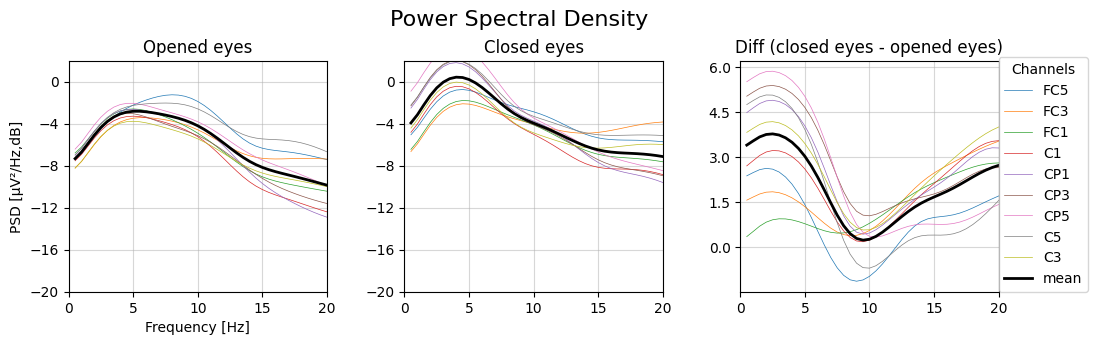

In [134]:
from src.visualization.check_alpha_rhythm import plot_alpha_spectr

fig = plot_alpha_spectr(freq, psd_motor_avg[idxs_ROA], psd_rest_avg[idxs_ROA], labels_ROA,  plot_mean=True,
                 freq_min = 0, freq_max=20, to_db=True, y_min=-20, y_max=2)

In [ ]:
f, t, S = compute_windowed_fft(reref_eeg, fs=Fs)

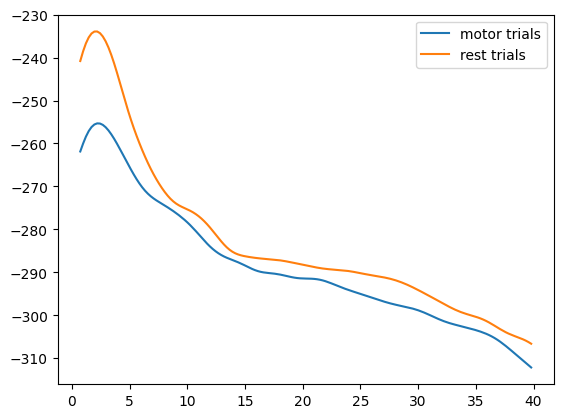

In [173]:
psd_m_ROA = np.mean(psd_m[idx_ROA], axis=0)
psd_r_ROA = np.mean(psd_r[idx_ROA], axis=0)
plt.plot(freqs, psd_m_ROA, label="motor trials")
plt.plot(freqs, psd_r_ROA, label="rest trials")
# plt.xlim(0, 40)
plt.legend()

array([-261.86129127, -260.02560181, -258.40810189, -257.11208249,
       -256.16944466, -255.57677794, -255.3140034 , -255.35307499,
       -255.66181555, -256.20562556, -256.94846304, -257.85378629,
       -258.88572784, -260.01044723, -261.19735593, -262.41978548,
       -263.65476778, -264.88192549, -266.08190615, -267.23512544,
       -268.32162331, -269.3224952 , -270.22269299, -271.01423029,
       -271.69839429, -272.28585888, -272.79455698, -273.24618119,
       -273.6625808 , -274.06301457, -274.46262758, -274.87207239,
       -275.29801812, -275.74427282, -276.21323264, -276.70730405,
       -277.22987813, -277.78547908, -278.37892407, -279.01366069,
       -279.68974456, -280.40206687, -281.13944122, -281.88506867,
       -282.61868434, -283.32013223, -283.97314468, -284.56747295,
       -285.09847209, -285.56535587, -285.97020952, -286.31852016,
       -286.6201993 , -286.88957728, -287.14367083, -287.39916063,
       -287.66911764, -287.96043305, -288.27249479, -288.59729

In [ ]:
psd_diff = psd_r-psd_m

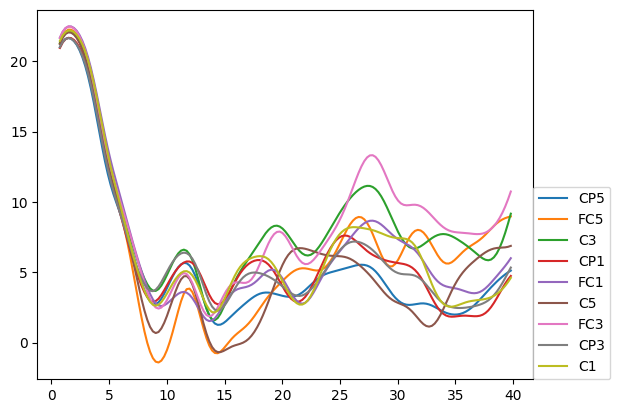

In [160]:
idx_5 = np.where(freqs > 10)[0][0]
idx_15 = np.where(freqs < 12)[0][-1]
for (spectr, ch) in list(zip(psd_diff, ch_labels)):
    # if max(spectr[idx_5:idx_15]) < 6:
    #     continue
    if not ch in ROA:
        continue
    plt.plot(freqs, spectr, label=ch)
# plt.xlim(0, 40)
plt.legend(loc=[1,0])


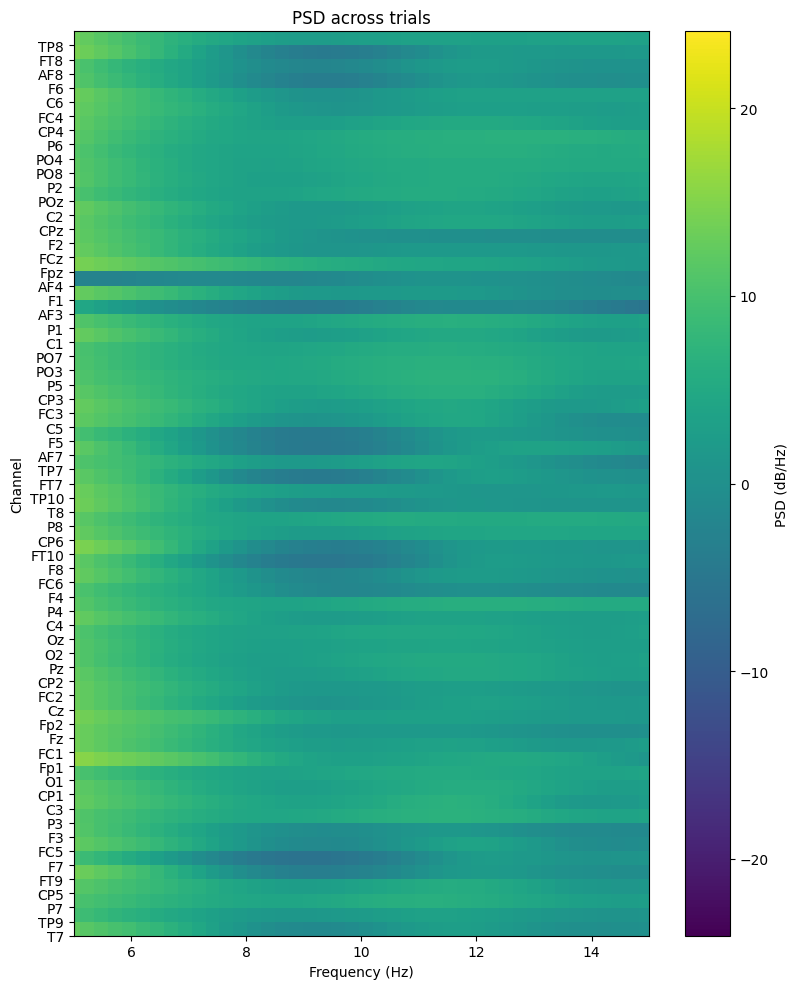

In [ ]:
plt.figure(figsize=(8, 10))

abs_max = np.nanmax(np.abs(psd_diff))
im = plt.imshow(
    psd_diff,
    aspect='auto',
    origin='lower',
    extent=[freqs[0], freqs[-1], 0, psd_r.shape[0]],
    vmin=-abs_max,
    vmax=abs_max,
)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Channel')
plt.title('PSD across trials')
plt.colorbar(im, label='PSD (dB/Hz)')
plt.tight_layout()
plt.yticks(np.arange(psd_r.shape[0]), ch_labels)
plt.xlim(5, 15)
plt.show()

In [96]:
freqs

array([  0.     ,   3.90625,   7.8125 ,  11.71875,  15.625  ,  19.53125,
        23.4375 ,  27.34375,  31.25   ,  35.15625,  39.0625 ,  42.96875,
        46.875  ,  50.78125,  54.6875 ,  58.59375,  62.5    ,  66.40625,
        70.3125 ,  74.21875,  78.125  ,  82.03125,  85.9375 ,  89.84375,
        93.75   ,  97.65625, 101.5625 , 105.46875, 109.375  , 113.28125,
       117.1875 , 121.09375, 125.     , 128.90625, 132.8125 , 136.71875,
       140.625  , 144.53125, 148.4375 , 152.34375, 156.25   , 160.15625,
       164.0625 , 167.96875, 171.875  , 175.78125, 179.6875 , 183.59375,
       187.5    , 191.40625, 195.3125 , 199.21875, 203.125  , 207.03125,
       210.9375 , 214.84375, 218.75   , 222.65625, 226.5625 , 230.46875,
       234.375  , 238.28125, 242.1875 , 246.09375, 250.     , 253.90625,
       257.8125 , 261.71875, 265.625  , 269.53125, 273.4375 , 277.34375,
       281.25   , 285.15625, 289.0625 , 292.96875, 296.875  , 300.78125,
       304.6875 , 308.59375, 312.5    , 316.40625, 

## Observations

- Фотометка не может быть устроен так всрато.

Next steps:
- Check ICA components
- Exclude sub-03?